In [9]:
from __future__ import division
from abc import ABCMeta, abstractmethod
import numpy as np
import matplotlib.pyplot as pl
import scipy.optimize as so
import scipy.linalg as sl
import scipy.sparse as ss
import matplotlib.lines as mlines
import networkx as nx
import pandas as pd
import random
import time
from tqdm import tqdm

# %%
class iconshapes:
    # circles
    blue_circle = mlines.Line2D(
        [], [], color="blue", marker="o", linestyle="None", markersize=10
    )
    red_circle = mlines.Line2D(
        [], [], color="red", marker="o", linestyle="None", markersize=10
    )
    green_circle = mlines.Line2D(
        [], [], color="green", marker="o", linestyle="None", markersize=10
    )
    gray_circle = mlines.Line2D(
        [], [], color="gray", marker="o", linestyle="None", markersize=10
    )
    # triangles
    blue_triangle = mlines.Line2D(
        [], [], color="blue", marker="v", linestyle="None", markersize=10
    )
    red_triangle = mlines.Line2D(
        [], [], color="red", marker="v", linestyle="None", markersize=10
    )
    green_triangle = mlines.Line2D(
        [], [], color="green", marker="v", linestyle="None", markersize=10
    )
    # squares
    blue_square = mlines.Line2D(
        [], [], color="blue", marker="s", linestyle="None", markersize=10
    )
    red_square = mlines.Line2D(
        [], [], color="red", marker="s", linestyle="None", markersize=10
    )
    green_square = mlines.Line2D(
        [], [], color="green", marker="s", linestyle="None", markersize=10
    )


# Values required for approximating the logistic sigmoid by
# error functions. coefs are obtained via:
# x = np.array([0, 0.6, 2, 3.5, 4.5, np.inf])
# b = logistic(x)
# A = (erf(np.dot(x, self.lambdas)) + 1) / 2
# coefs = lstsq(A, b)[0]
# LAMBDAS = np.array([0.41, 0.4, 0.37, 0.44, 0.39])[:, np.newaxis]
LAMBDAS = np.array([0.41, 0.4, 0.37, 0.44, 0.39])
COEFS = np.array(
    [-1854.8214151, 3516.89893646, 221.29346712, 128.12323805, -2010.49422654]
)[:, np.newaxis]


# %%
class GPnetBase:
    __metaclass_ = "GPnetBase"
    """ GPnetBase class cointains common attributes and methods for GPnetClassifier 
    and GPnetRegressor
    
    
    Attributes
    ----------
    
    Graph : network Graph
        NetworkX Graph on which regression/classification is made, if no graph
        is provided random regular graph is generated
    totnodes : int
        total number of nodes (for random graph generation)
    ntrain : int
        number of training nodes
    ntest : int
        number of test nodes
    deg : int
        connectivity degree (for random graph generation)
    seed : int
        seed for random number generation
    training_nodes: list
        list of nodes that are used for training
    test_nodes: list
        list of test nodes
    training_values: pandas Series (will be changed in future)
        training labels
    theta: list
        list of kernel parameters [a, b, c, d]
        a : constant term
        b : constant scale
        c : length scale
        d : noise term
        notice that kernel parameters are exponentiated, take np.log(theta) in
        advance
    optimize: bool
        if True activates the kernel parameter optimizer
    relabel_nodes: bool
        if True the nodes are relabelled to consecutive integers
    kerneltype: string
        "diffusion"
        "regularized_laplacian"
        "pstep_walk"
        
    Methods
    ----------
    calc_shortest_paths():
        calculates the shortest path matrix using Dijkstra's algorithm
    pivot_distance(pivot=0)
        returns pivot distance list respect to pivot
    random_assign_nodes():
        assigns nodes to training and test randomly, uses GPnet.seed
    kernel(nodes_a, nodes_b, theta, measnoise=1.0, wantderiv=True)
        calculates covariance matrix between nodes_a and nodes_b with
        theta parameters
    is_pos_def(test_mat):
        returns True if test_mat is positive definite
    logp()
        returns LogMarginalLikelihood
    plot_graph(filename=False):
        plots Graph with training/test/other labels
        if filename is defined saves plot as filename.png
    plot_prior():
        plots 5 extractions from prior process distribution
        if filename is defined saves plot as filename.png
    plot_post():
        plots 5 extractions from posterior process distribution
        if filename is defined saves plot as filename.png
    """

    def __init__(
        self,
        Graph,
        totnodes,
        ntrain,
        ntest,
        deg,
        seed,
        training_nodes,
        training_values,
        test_nodes,
        theta,
        optimize,
        relabel_nodes,
        kerneltype,
    ):
        self.N = ntrain
        self.n = ntest
        self.deg = deg
        self.seed = seed

        self.is_trained = False
        self.optimize = optimize

        self.theta = theta

        self.relabel_nodes = relabel_nodes
        self.kerneltype = kerneltype
        if totnodes == False:
            self.totnodes = self.N + self.n
        else:
            self.totnodes = totnodes

        if Graph == False:
            print("> Initializing Random Regular Graph")
            print(self.totnodes, "nodes")
            print("node degree", self.deg)
            G = nx.random_regular_graph(deg, totnodes)

        else:
            G = Graph
            self.totnodes = len(Graph.nodes)

        self.Graph = Graph

        self.orig_labels_dict = dict(zip(G, range(len(G.nodes))))
        self.orig_labels_invdict = dict(
            [[v, k] for k, v in self.orig_labels_dict.items()]
        )

        if relabel_nodes == True:
            print("> Relabeling nodes, orig. names stored in self.orig_labels_dict")
            self.Graph = nx.relabel_nodes(G, self.orig_labels_dict)

        self.training_nodes = training_nodes
        self.test_nodes = test_nodes
        # self.other_nodes = other_nodes

        if training_nodes == False or test_nodes == False:
            print("> Assigning Nodes Randomly ( seed =", self.seed, ")")
            print(self.N, " training nodes")
            print(self.n, " test nodes")
            print((self.totnodes - (self.N + self.n)), " idle nodes")

            self.random_assign_nodes()

        self.assign_other_nodes()
        self.calc_shortest_paths()

        # init plot stuff
        self.plot_pos = nx.kamada_kawai_layout(self.Graph)
        
        # shortest paths
        self.calc_pivot_distance()


        # END INIT #
        return

    def pivot_distance(self, pivot=0):
        pivot_distance = pd.Series(
            dict(nx.single_source_shortest_path_length(self.Graph, pivot))
        ).sort_index()
        pivot_distance.name = "pivot distance"
        return pivot_distance

    def calc_shortest_paths(self):
        # shortest_paths_lengths = dict(nx.all_pairs_shortest_path_length(G))
        shortest_paths_lengths = dict(nx.all_pairs_shortest_path_length(self.Graph))
        self.dist = pd.DataFrame(shortest_paths_lengths).sort_index(axis=1)
        return

    def random_assign_nodes(self):

        if self.N + self.n > self.totnodes:
            raise ValueError(
                "tot. nodes cannot be less than training nodes + test nodes"
            )
        # training_nodes = list(G.nodes)[0:N]
        random.seed(self.seed)
        self.training_nodes = random.sample(list(self.Graph.nodes), self.N)
        self.training_nodes.sort()

        # test_nodes = list(G.nodes)[N:N+n]
        self.test_nodes = random.sample(
            (set(self.Graph.nodes) - set(self.training_nodes)), self.n
        )
        self.test_nodes.sort()

        self.assign_other_nodes()
        return self

    def assign_other_nodes(self):

        self.other_nodes = (
            set(self.Graph.nodes) - set(self.training_nodes) - set(self.test_nodes)
        )
        self.other_nodes = list(self.other_nodes)
        self.other_nodes.sort()

        return self

    def optimize_params(self, gtol=1e-3, maxiter=200, disp=1):
        if self.optimize != False:
            print("> Optimizing parameters")
            print("method used: ", self.optimize["method"])
            print("bounds: ", self.optimize["bounds"])
            res = so.minimize(
                fun=self.logPosterior,
                x0=self.theta,
                args=(self.training_nodes, self.training_values),
                method=self.optimize["method"],
                bounds=self.optimize["bounds"],
                options={"disp": True},
            )
            self.theta = res["x"]
            print("new parameters: ", self.theta)
        return self

    def kernel(self, nodes_a, nodes_b, theta, measnoise=1.0, wantderiv=True):
        """
        Kernel Function
        ---------------
        
        k(nodes_a, nodes_b) = exp(a) + exp(b) * exp(-1/2 * (dist/exp(c))^2) + I*d
        
        with theta=[a,b,c,d]
        
        
        Parameters
        ----------
        
        nodes_a, nodes_b : list
            list of nodes between which the correlation matrix is calculated
        theta: 
            parameters, described aboce
        measnoise: 
            scale for measured noise ( just testing purposes )
        wantderiv:
            if True returns a k[len(nodes_a), len(nodes_b), len(theta) +1] ndarray
            k[:,:,0] is the covariance matrix
            K[:,:,j] are the the j-th partial derivatives respect to parameters
        """
        if not len(theta) == 1:
            theta = np.squeeze(theta)

        theta = np.exp(theta)
        # graph_distance_matrix = shortest_path_graph_distances(Graph)
        nodelist = list(self.Graph.nodes)
        nodeset = set(nodes_a).union(set(nodes_b))
        nodes_to_drop = [x for x in nodelist if x not in nodeset]
        cols_to_dropset = set(nodes_to_drop).union(set(nodes_b) - set(nodes_a))
        rows_to_dropset = set(nodes_to_drop).union(set(nodes_a) - set(nodes_b))

        cols_to_keepset = nodeset - cols_to_dropset
        rows_to_keepset = nodeset - rows_to_dropset

        if self.relabel_nodes == False:
            cols_to_drop = [self.orig_labels_dict[idx] for idx in cols_to_dropset]
            rows_to_drop = [self.orig_labels_dict[idx] for idx in rows_to_dropset]
            cols_to_keep = [self.orig_labels_dict[idx] for idx in cols_to_keepset]
            rows_to_keep = [self.orig_labels_dict[idx] for idx in rows_to_keepset]
        else:
            cols_to_drop = list(cols_to_dropset)
            rows_to_drop = list(rows_to_dropset)
            cols_to_keep = list(cols_to_keepset)
            rows_to_keep = list(rows_to_keepset)

        # need to keep track of node names somehow
        d1 = len(nodes_a)
        d2 = len(nodes_b)

        Lnorm = ss.csc_matrix(nx.normalized_laplacian_matrix(self.Graph))

        # maybe it's wrong
        #        Lnorm = Lnorm[:, cols_to_keep]
        #        Lnorm = Lnorm[rows_to_keep, :]
        # ok ofcourse it doesnt work
        kernel_list = ("diffusion", "regularized_laplacian", "pstep_walk")

        assert self.kerneltype in kernel_list, "kerneltype not implemented"
        if self.kerneltype == "diffusion":
            assert theta[0] < 1, "Lambda must be < 1" % theta[0]
            K = sl.expm(-theta[0] * Lnorm).toarray()
        elif self.kerneltype == "regularized_laplacian":
            K = sl.inv(np.eye(len(self.Graph.nodes())) + theta[0] * Lnorm).toarray()
        elif self.kerneltype == "pstep_walk":
            assert theta[0] >= 2, "a must be >=2" % theta[0]
            K = np.asarray(
                np.linalg.matrix_power(
                    theta[0] * np.eye(len(self.Graph.nodes())) - Lnorm, int(theta[1])
                )
            )

        # Lnorm2 = ss.csc_matrix(np.eye(len(self.Graph.nodes())) + theta[0]*nx.normalized_laplacian_matrix(self.Graph))
        # DIFFUSION PROCESS KERNEL

        # REGULARIZED LAPLACIAN KERNEL
        # K = sl.inv(np.eye(len(self.Graph.nodes())) + theta[0]*Lnorm)

        # P-STEP

        # K = sl.matrix_power(ss.csc_matrix(theta[0]*np.eye(len(self.Graph.nodes()))) - Lnorm, 3)
        # K = np.linalg.matrix_power(theta[0]*np.eye(len(nodelist)) - Lnorm.toarray(), 5)

        k = np.delete(K, cols_to_drop, axis=0)
        k = np.delete(k, rows_to_drop, axis=1)

        k = k + measnoise * theta[-1]

        return k

    @abstractmethod
    def logPosterior(self, theta, *args):
        raise NotImplementedError(
            "logPosterior() must be overridden by GPnetRegressor or GPnetClassifier"
        )

    def logp(self):
        return -self.logPosterior(self.theta, self.training_nodes, self.training_values)

    def plot_graph(self, filename=False):
        pl.figure(figsize=[15, 9])
        pl.title("Graph")
        # node positions
        # draw nodes
        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            #with_labels=True,
            node_size=200,
            nodelist=self.training_nodes,
            node_color="r",
        )
        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            #with_labels=True,
            node_size=200,
            nodelist=self.test_nodes,
            node_color="g",
        )
        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            #with_labels=True,
            node_size=200,
            nodelist=self.other_nodes,
            node_color="b",
        )
        # draw edges
        ec = nx.draw_networkx_edges(self.Graph, self.plot_pos, alpha=0.2)
        # legend
        if self.relabel_nodes == True:
            labels = nx.draw_networkx_labels(
                self.Graph,
                labels=self.orig_labels_invdict,
                pos=self.plot_pos,
                font_color="k",
            )
        else:
            labels = nx.draw_networkx_labels(
                self.Graph, pos=self.plot_pos, font_color="k"
            )
        # legend
        training_patch = iconshapes.red_circle
        training_patch._label = "training nodes"
        test_patch = iconshapes.green_circle
        test_patch._label = "test nodes"
        other_patch = iconshapes.blue_circle
        other_patch._label = "other nodes"

        pl.legend(handles=[training_patch, test_patch, other_patch])

        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        return self

    def plot_prior(self, filename=False):
        L2 = np.linalg.cholesky(self.kstarstar + 1e-6 * np.eye(self.n))
        # f_prior = mu L*N(0,1)
        f_prior = np.dot(L2, np.random.normal(size=(self.n, 5)))
        pl.figure()
        pl.clf()
        pl.plot(self.test_nodes, f_prior)
        pl.title("5 estrazioni dalla dist. a priori")
        pl.xlabel("nodes")
        pl.ylabel("values")
        # pl.axis([-5, 5, -3, 3])
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")

    def plot_post(self, filename=False):
        Lk = np.linalg.solve(self.L, self.kstar.T)
        L2 = np.linalg.cholesky(
            self.kstarstar + 1e-6 * np.eye(self.n) - np.dot(Lk.T, Lk)
        )

        # f_post = mu + L*N(0,1)
        f_post = self.fstar.reshape(-1, 1) + np.dot(
            L2, np.random.normal(size=(self.n, 5))
        )
        pl.figure()
        pl.clf()
        pl.plot(self.test_nodes, f_post)
        pl.title("5 estrazioni dalla dist. a posteriori")
        pl.xlabel("nodes")
        pl.ylabel("values")
        # pl.axis([-5, 5, -3, 3])
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")

    def plot_lml_landscape(self, plots, params, filename=False):
        pl.rcParams.update({"font.size": 5})
        plcols = 3
        #        if len(plots)%plcols != 0:
        #            plrows = len(plots)//plcols +1
        #        else:
        #            plrows = len(plots)//plcols
        plrows = len(plots) // plcols
        # print(plrows, " - ", plcols, "<")

        fig, ax = pl.subplots(plrows, plcols, dpi=300)
        fig.suptitle("LML landscapes", size=10)
        fig.subplots_adjust(wspace=0.3, hspace=0.4)
        for index, item in enumerate(plots):
            # print("Index: ", index)
            plot = plots[item]
            lml = self.lml_landscape(params, plot[0], plot[1], plot[2])
            idxmax = np.unravel_index(np.argmax(lml, axis=None), lml.shape)
            print(idxmax, lml[idxmax])
            idx1 = index // plcols
            idx2 = index % plcols
            if plrows == 0:
                idx = idx2
            else:
                idx = (idx1, idx2)

            # print(idx1, " - ", idx2)
            if plrows != 0:
                if len(plot) == 4:
                    cax = ax[idx].pcolor(plot[2], plot[1], lml)
                ax[idx].plot(
                    [plot[3][1]], [plot[3][0]], marker="o", markersize=5, color="red"
                )
                ax[idx].plot(
                    [plot[2][idxmax[0]]],
                    [plot[1][idxmax[1]]],
                    marker="o",
                    markersize=5,
                    color="blue",
                )
                ax[idx].set(
                    xlabel="theta" + str(plot[0][0]),
                    ylabel="theta" + str(plot[0][1]),
                    title=item,
                )
                # ax[idx1, idx2].set_title(item)
                fig.colorbar(cax, ax=ax[idx])
            else:
                if len(plot) == 4:
                    cax = pl.pcolor(plot[2], plot[1], lml)
                pl.plot(
                    [plot[3][1]], [plot[3][0]], marker="o", markersize=5, color="red"
                )
                pl.plot(
                    [plot[2][idxmax[0]]],
                    [plot[1][idxmax[1]]],
                    marker="x",
                    markersize=5,
                    color="blue",
                )
                pl.xlabel("theta" + str(plot[0][0]))
                pl.ylabel("theta" + str(plot[0][1]))
                pl.title(item)
                #                fig.set(
                #                        xlabel="theta" + str(plot[0][0]),
                #                        ylabel="theta" + str(plot[0][1]),
                #                        title=item,
                #                )
                pl.colorbar(cax)

    def lml_landscape(self, theta, axidx, ax1, ax2):
        print("> Calculating LML Landscape")
        lml = np.zeros([len(ax1), len(ax2)])
        for i in tqdm(range(len(ax1))):
            for j in range(len(ax2)):
                params = theta
                params[axidx[0]] = ax1[i]
                params[axidx[1]] = ax2[j]
                # print(axidx[0], axidx[1])

                lml[i, j] = -self.logPosterior(
                    params, self.training_nodes, self.training_values
                )
        return lml

    def set_training_values(self, training_values):
        self.training_values = training_values
        self.training_values.name = "training values"

    def calc_ktot(self):
        self.ktot = self.kernel(
            nodes_a=self.Graph.nodes,
            nodes_b=self.Graph.nodes,
            theta=self.theta,
            wantderiv=False,
        )
        
    def int_to_list(nodes):
        if type(nodes) == int:
            return [nodes]
        else:
            return nodes    
        
    def is_pos_def(self, test_mat):
        return np.all(np.linalg.eigvals(test_mat) > 0)
    
    
    def generate_df(self):
        fstar_series = pd.Series(index=self.test_nodes, data=self.fstar)
        s_series = pd.Series(index=self.test_nodes, data=self.s)
        
        try:
            self.predicted_probs
        except AttributeError:
            probs_series0 = pd.Series(index = self.test_nodes)
            probs_series1 = pd.Series(index = self.test_nodes)
            predicted_class_series = pd.Series(index = self.test_nodes)
        else:
            probs_series0 = pd.Series(index = self.test_nodes, data=self.predicted_probs.T[0])
            probs_series1 = pd.Series(index = self.test_nodes, data=self.predicted_probs.T[1])

        predicted_class_series = probs_series0.copy()
        predicted_class_series[predicted_class_series >0.5] = 1
        predicted_class_series[predicted_class_series <= 0.5] = -1            
        
        self.df = pd.DataFrame()
        self.df = self.df.assign(
            pvtdist=self.pvtdist,
            train_vals=self.training_values,
            fstar=fstar_series,
            variance_s=s_series,
            prob_0 = probs_series0,
            prob_1 = probs_series1,
            predicted_class = -predicted_class_series
        )
        
        return self
    
    def calc_pivot_distance(self):
        self.pvtdist = self.pivot_distance(list(self.Graph.nodes)[0])
        return self
        

In [10]:
# from GPnet import GPnetBase, iconshapes
import numpy as np
import networkx as nx
import matplotlib.pylab as pl
import pandas as pd


class GPnetRegressor(GPnetBase):
    """
    Class for Regressors
    
    
    Methods
    ---------
    
    predict():
        calculates predictions using training labels
    predict_RW():
        same thing, just implemented differently (to be removed)
    logPosterior(theta, data, labels):
        returns -log marginal likelihood
    gradlogposterior(theta, data, labels):
        returns - gradient(logposterior)
    optimize_params():
        optimizer
    plot_predict_2d(filename=False):
        plots post Gaussian Process in 2d fashion, with node number on x
        if filename is specified saves plot to 'filename.png'
    plot_predict_graph(filename=False):
        plots graph, node's color is proportional to process prediction
        if filename is specified saves plot to 'filename.png'
    set_training_values(training_values):
        set training values to training_values
        
    """

    def __init__(
        self,
        Graph=False,
        totnodes=False,
        ntrain=100,
        ntest=90,
        deg=4,
        seed=0,
        training_nodes=False,
        training_values=False,
        test_nodes=False,
        theta=[0.1, 0.1, 0.1],
        optimize=False,
        relabel_nodes=False,
        kerneltype="diffusion",
    ):

        super(GPnetRegressor, self).__init__(
            Graph,
            totnodes,
            ntrain,
            ntest,
            deg,
            seed,
            training_nodes,
            training_values,
            test_nodes,
            theta,
            optimize,
            relabel_nodes,
            kerneltype,
        )
        
        self.pivot_flag = False
        if training_values == False:
            self.pivot_flag = True
            self.training_values = self.pvtdist[self.training_nodes]
        else:
            self.training_values = training_values
            
        return
    
    def predict(self):
        # predicts the same exact results as GPnetRegressor.predict(), just reimplemented using Algorithm 2.1 in Rasmussen to make sure it was not the problem
        self.optimize_params()

        self.k_not_posdef_flag = False
        self.kstar_not_posdef_flag = False

        self.t_mean = np.mean(self.training_values)
        self.t_shifted = self.training_values - self.t_mean

        self.k = self.kernel(
            nodes_a=self.training_nodes,
            nodes_b=self.training_nodes,
            theta=self.theta,
            wantderiv=False,
        )

        self.kstar = self.kernel(
            nodes_a=self.test_nodes,
            nodes_b=self.training_nodes,
            theta=self.theta,
            wantderiv=False,
            measnoise=False,
        )
        self.kstarstar = self.kernel(
            nodes_a=self.test_nodes,
            nodes_b=self.test_nodes,
            theta=self.theta,
            wantderiv=False,
        )

        self.kstarstar_diag = np.diag(self.kstarstar)

        if not self.is_pos_def(self.k):
            self.k_not_posdef_flag = True
            # raise ValueError("K is not positive definite")
            print("K not positive definite, aborting...")
            return self
        if not self.is_pos_def(self.kstarstar):
            self.kstar_not_posdef_flag = True
            # raise ValueError("K** is not positive definite")
            print("K** not positive definite, aborting...")
            return self

        self.L = np.linalg.cholesky(self.k)
        self.alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.t_shifted))
        self.fstar = np.dot(self.kstar, self.alpha) + self.t_mean
        self.v = np.linalg.solve(self.L, self.kstar.T)
        self.V = self.kstarstar_diag - np.dot(self.v.T, self.v)
        self.s = np.sqrt(np.diag(self.V))

        print("succesfully trained model")
        self.is_trained = True
        self.generate_df()

        return self

    def logPosterior(self, theta, *args):
        data, t = args

        K = self.kernel(data, data, theta, wantderiv=False)
        try:
            L = np.linalg.cholesky(K)
        except np.linalg.LinAlgError:
            return -np.inf
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, t))
        logp = (
            -0.5 * np.dot(t.T, alpha)
            - np.sum(np.log(np.diag(L)))
            - K.shape[0] * 0.5 * np.log(2 * np.pi)
        )
        return -logp

    def gradLogPosterior(self, theta, *args):
        data, t = args
        theta = np.squeeze(theta)
        k = self.kernel(data, data, theta, wantderiv=True)
        try:
            L = np.linalg.cholesky(k[:, :, 0])  # Line 2
            K_inv = np.dot(np.linalg.inv(L).T, np.linalg.inv(L))
        except np.linalg.LinAlgError:
            return -np.inf
        # return (-np.inf, np.zeros_like(theta)) if eval_gradient else -np.inf

        # L = np.linalg.cholesky(k)
        alpha = np.linalg.solve(L, t)

        tmp = np.eye(k.shape[0]) * np.dot(alpha, alpha.T)
        # tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k: output-dimension
        # tmp2 = np.linalg.solve(L, np.eye(k.shape[0]))[:, :, np.newaxis]
        tmp -= K_inv
        # Compute "0.5 * trace(tmp.dot(K_gradient))" without
        # constructing the full matrix tmp.dot(K_gradient) since only
        # its diagonal is required
        log_likelihood_gradient_dim = np.zeros([len(data), len(data), len(theta)])
        for i in range(0, len(theta)):
            log_likelihood_gradient_dim[:, :, i] = 0.5 * np.dot(tmp, k[:, :, i + 1])
            log_likelihood_gradient = np.trace(log_likelihood_gradient_dim, axis1=0)

        # log_likelihood_gradient_dims = 0.5 * np.einsum("ij,ijk->ijk", tmp, k[:, :, 1:])
        # log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)
        print(log_likelihood_gradient)
        return -log_likelihood_gradient



    def gen_cmap(self):
        self.vmin = min(self.training_values.min(), self.fstar.min())
        self.vmax = max(self.training_values.max(), self.fstar.max())
        self.cmap = pl.cm.inferno_r

    def plot_predict_2d_old(self, filename=False):
        pl.figure(figsize=[15, 9])
        pl.clf()
        # pl.plot(self.training_nodes, self.training_values, "r+", ms=20)
        #        pl.gca().fill_between(
        #            self.test_nodes, self.fstar - self.s, self.fstar + self.s, color="#dddddd"
        #        )
        #        pl.plot(self.test_nodes, self.fstar, "ro", ms=4)
        #        pl.plot(self.test_nodes, self.fstar, "r--", lw=2)
        errorbar_df = self.df.iloc[list(self.test_nodes)]
        pl.errorbar(
            errorbar_df.index,
            errorbar_df["fstar"],
            errorbar_df["variance_s"],
            barsabove=True,
            ecolor="black",
            linewidth=1,
            capsize=5,
            fmt="o",
        )
        plot_df = self.df.iloc[list(self.training_nodes)]
        pl.plot(plot_df.index, plot_df["train_vals"].values, "r+", ms=20)
        #        pl.errorbar(self.test_nodes, self.fstar,self.s,
        #                    barsabove = True,
        #                    ecolor = "black",
        #                    linewidth = 1,
        #                    capsize = 5,
        #                    fmt = 'o')
#        if self.pivot_flag == True:
#            pvt_dist_df = self.df
#            pl.plot(pvt_dist_df.index, pvt_dist_df["pvtdist"].values)
        pl.title("Gaussian Process Mean and Variance")
        # loglikelihood = -self.logPosterior(self.theta, self.training_nodes, self.training_values)
        #        pl.title(
        #            "Valore medio e margini a posteriori\n(length scale: %.3f , constant scale: %.3f , noise variance: %.3f )\n Log-Likelihood: %.3f"
        #            % (self.theta[1], self.theta[0], self.theta[2], loglikelihood)
        #        )
        #        pl.title(
        #            "Valore medio e margini a posteriori\n(lambda: %.3f)" % (self.theta[0])
        #        )
        pl.xlabel("nodes")
        pl.ylabel("values")
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        # pl.axis([-5, 5, -3, 3])
        return self

    def plot_predict_2d(self, filename=False):
        pl.figure(figsize=[15, 9])
        pl.clf()
        # pl.plot(self.training_nodes, self.training_values, "r+", ms=20)
        #        pl.gca().fill_between(
        #            self.test_nodes, self.fstar - self.s, self.fstar + self.s, color="#dddddd"
        #        )
        #        pl.plot(self.test_nodes, self.fstar, "ro", ms=4)
        #        pl.plot(self.test_nodes, self.fstar, "r--", lw=2)
        errorbar_df = self.df.iloc[list(self.test_nodes)].sort_values(by=["pvtdist"])
        pl.errorbar(
            errorbar_df["pvtdist"].values,
            errorbar_df["fstar"].values,
            errorbar_df["variance_s"].values,
            barsabove=True,
            ecolor="black",
            linewidth=1,
            capsize=5,
            fmt="o",
        )
        plot_df = self.df.iloc[list(self.training_nodes)].sort_values(by=["pvtdist"])
        pl.plot(plot_df["pvtdist"].values, plot_df["train_vals"].values, "r+", ms=20)
        #        pl.errorbar(self.test_nodes, self.fstar,self.s,
        #                    barsabove = True,
        #                    ecolor = "black",
        #                    linewidth = 1,
        #                    capsize = 5,
        #                    fmt = 'o')
        if self.pivot_flag == True:
            pvt_dist_df = self.df.sort_values(by=["pvtdist"])
            pl.plot(pvt_dist_df["pvtdist"].values, pvt_dist_df["pvtdist"].values)
        pl.title("Gaussian Process Mean and Variance")
        # loglikelihood = -self.logPosterior(self.theta, self.training_nodes, self.training_values)
        #        pl.title(
        #            "Valore medio e margini a posteriori\n(length scale: %.3f , constant scale: %.3f , noise variance: %.3f )\n Log-Likelihood: %.3f"
        #            % (self.theta[1], self.theta[0], self.theta[2], loglikelihood)
        #        )
        #        pl.title(
        #            "Valore medio e margini a posteriori\n(lambda: %.3f)" % (self.theta[0])
        #        )
        pl.xlabel("pivot distance")
        pl.ylabel("values")
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        # pl.axis([-5, 5, -3, 3])
        return self

    def plot_predict_graph(self, filename=False):

        if self.is_trained == False:
            print("need to train a model first, use GPnetRegressor.predict()")
            return

        pl.figure(figsize=[15, 9])
        pl.title("Prediction plot")

        self.gen_cmap()
        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            nodelist=self.training_nodes,
            node_color=np.squeeze(self.training_values[(self.training_nodes)]),
            #with_labels=True,
            node_size=200,
            cmap=self.cmap,
            node_shape="v",
        )

        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            nodelist=self.other_nodes,
            node_color="gray",
            #with_labels=True,
            node_size=200,
            cmap=self.cmap,
        )

        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            nodelist=self.test_nodes,
            node_color=self.fstar,
            #with_labels=True,
            node_size=200,
            cmap=self.cmap,
            node_shape="s",
        )

        ec = nx.draw_networkx_edges(self.Graph, self.plot_pos, alpha=0.2)

        sm = pl.cm.ScalarMappable(
            cmap=self.cmap, norm=pl.Normalize(vmin=self.vmin, vmax=self.vmax)
        )
        sm.set_array([])
        cbar = pl.colorbar(sm)

        labels = nx.draw_networkx_labels(self.Graph, pos=self.plot_pos, font_color="k")

        # legend
        training_patch = iconshapes.red_triangle
        training_patch._label = "training nodes"
        test_patch = iconshapes.green_square
        test_patch._label = "test nodes"
        other_patch = iconshapes.gray_circle
        other_patch._label = "other nodes"

        pl.legend(handles=[training_patch, test_patch, other_patch])

        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        return self

In [11]:
#from GPnet import GPnetBase, LAMBDAS, COEFS, iconshapes
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pylab as pl
from scipy.special import erf


class GPnetClassifier(GPnetBase):
    """
    Class for Classifiers
    
    
    Methods
    ---------
    predict():
        calculates predictions using training labels
    NRiteration(data, targets, theta, tol=0.1, phif=1e100, scale=1.):
        finds maximum f_star mode for Laplace Approximation
    logPosterior(theta, data, labels):
        returns -log marginal likelihood
    gradlogposterior(theta, data, labels):
        returns - gradient(logposterior)
    plot_latent(filename=False):
        plots latent Gaussian Process in 2d fashion, with node number on x
        if filename is specified saves plot to 'filename.png'
    plot_predict_graph(filename=False):
        plots graph, node's color is proportional to process prediction
        if filename is specified saves plot to 'filename.png'
    """

    def __init__(
        self,
        Graph=False,
        totnodes=False,
        ntrain=100,
        ntest=90,
        deg=4,
        seed=0,
        training_nodes=False,
        training_values=False,
        test_nodes=False,
        theta=[0.1, 0.1, 0.1],
        optimize=False,
        relabel_nodes=False,
        kerneltype="diffusion",
    ):

        super(GPnetClassifier, self).__init__(
            Graph,
            totnodes,
            ntrain,
            ntest,
            deg,
            seed,
            training_nodes,
            training_values,
            test_nodes,
            theta,
            optimize,
            relabel_nodes,
            kerneltype,
        )

        self.pivot_flag = False

        if isinstance(training_values, pd.Series) == False:
            print("no training labels where specified")
            print(
                "> Setting labels to (np.sin(0.6 * self.pvtdist) > 0).replace({True: 1, False: -1})"
            )
            self.pivot_flag = True
            self.pvtdist = self.pivot_distance(0)
            # self.t = self.pvtdist[self.training_nodes]
            self.binary_labels = (np.sin(0.6 * self.pvtdist) > 0).replace(
                {True: 1, False: -1}
            )
            self.training_values = self.binary_labels[self.training_nodes]

        else:
            self.training_values = training_values

        return

    def logPosterior(self, theta, *args):
        data, targets = args
        (f, logq, a) = self.NRiteration(data, targets, theta)
        return -logq

    def NRiteration(self, data, targets, theta, tol=0.1, phif=1e100, scale=1.0):
        # print("iteration")
        # pag 46 RASMUSSEN-WILLIAMS
        K = self.kernel(data, data, theta, wantderiv=False)

        n = np.shape(targets)[0]
        f = np.zeros((n, 1))
        #        tol = 0.1
        #        phif = 1e100
        #        scale = 1.
        count = 0
        targets = targets.values.reshape(n, 1)
        while True:

            count += 1
            # s = np.where(f < 0, f, 0)
            W = np.diag(np.squeeze(np.exp(-f) / (1 + np.exp(-f)) ** 2))

            sqrtW = np.sqrt(W)
            # L = cholesky(B)
            L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW, np.dot(K, sqrtW)))
            p = 1 / (1 + np.exp(-f))
            b = np.dot(W, f) + 0.5 * (targets + 1) - p
            a = scale * (
                b
                - np.dot(
                    sqrtW,
                    np.linalg.solve(
                        L.transpose(), np.linalg.solve(L, np.dot(sqrtW, np.dot(K, b)))
                    ),
                )
            )
            f = np.dot(K, a)
            oldphif = phif
            phif = (
                np.log(p)
                - 0.5 * np.dot(f.transpose(), np.dot(np.linalg.inv(K), f))
                - 0.5 * np.sum(np.log(np.diag(L)))
                - np.shape(data)[0] / 2.0 * np.log(2 * np.pi)
            )
            # print(phif)
            # print("loop",np.sum((oldphif-phif)**2))
            if np.sum((oldphif - phif) ** 2) < tol:
                break
            elif count > 100:
                count = 0
                scale = scale / 2.0

        s = -targets * f
        # ps = np.where(s > 0, s, 0)
        # logq = -0.5*np.dot(a.transpose(),f) -np.sum(np.log(ps+np.log(np.exp(-ps) + np.exp(s-ps)))) - np.trace(np.log(L))
        logq = (
            -0.5 * np.dot(a.transpose(), f)
            - np.sum(np.log(1 + np.log(1 + np.exp(-s))))
            - sum(np.log(L.diagonal()))
        )

        return (f, logq, a)

    def gradLogPosterior(self, theta, *args):
        data, targets = args
        theta = np.squeeze(theta)
        n = np.shape(targets)[0]
        K = self.kernel(data, data, theta, wantderiv=True)
        # K = kernel(data,data,theta,wantderiv=True)
        (f, logq, a) = self.NRiteration(data, targets, theta)
        s = np.where(f < 0, f, 0)
        W = np.diag(np.squeeze(np.exp(2 * s - f) / ((np.exp(s) + np.exp(s - f)) ** 2)))
        sqrtW = np.sqrt(W)
        L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW, np.dot(K[:, :, 0], sqrtW)))

        R = np.dot(sqrtW, np.linalg.solve(L.transpose(), np.linalg.solve(L, sqrtW)))
        C = np.linalg.solve(L, np.dot(sqrtW, K[:, :, 0]))
        p = np.exp(s) / (np.exp(s) + np.exp(s - f))
        hess = -np.exp(2 * s - f) / (np.exp(s) + np.exp(s - f)) ** 2
        s2 = -0.5 * np.dot(
            np.diag(np.diag(K[:, :, 0]) - np.diag(np.dot(C.transpose(), C))),
            2 * hess * (0.5 - p),
        )

        targets = targets.values.reshape(n, 1)

        gradZ = np.zeros(len(theta))
        for d in range(1, len(theta) + 1):
            s1 = 0.5 * (np.dot(a.transpose(), np.dot(K[:, :, d], a))) - 0.5 * np.trace(
                np.dot(R, K[:, :, d])
            )
            b = np.dot(K[:, :, d], (targets + 1) * 0.5 - p)
            p = np.exp(s) / (np.exp(s) + np.exp(s - f))
            s3 = b - np.dot(K[:, :, 0], np.dot(R, b))
            gradZ[d - 1] = s1 + np.dot(s2.transpose(), s3)

        return -gradZ

    def predict(self):
        # vedi algoritmo 3.2 Rasmussen
        if self.optimize != False:
            self.optimize_params()

        K = self.kernel(
            self.training_nodes, self.training_nodes, self.theta, wantderiv=False
        )
        n = np.shape(self.training_values)[0]
        kstar = self.kernel(
            self.training_nodes,
            self.test_nodes,
            self.theta,
            wantderiv=False,
            measnoise=0,
        )
        (f, logq, a) = self.NRiteration(
            self.training_nodes, self.training_values, self.theta
        )
        targets = self.training_values.values.reshape(n, 1)
        s = np.where(f < 0, f, 0)
        # step 2
        W = np.diag(np.squeeze(np.exp(2 * s - f) / ((np.exp(s) + np.exp(s - f)) ** 2)))
        sqrtW = np.sqrt(W)
        L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW, np.dot(K, sqrtW)))
        p = np.exp(s) / (np.exp(s) + np.exp(s - f))
        self.fstar = np.squeeze(np.dot(kstar.transpose(), (targets + 1) * 0.5 - p))
        v = np.linalg.solve(L, np.dot(sqrtW, kstar))
        kstarstar = self.kernel(
            self.test_nodes, self.test_nodes, self.theta, wantderiv=False, measnoise=0
        ).diagonal()
        module_v = np.dot(v.transpose(), v)

        self.V = (kstarstar - module_v).diagonal()

        # V = self.kernel(self.test_nodes,self.test_nodes,self.theta,wantderiv=False,measnoise=0).diagonal()-np.dot(v.transpose(),v)

        alpha = np.tile((1 / (2 * self.V)), (5, 1))
        # gamma = LAMBDAS * fstar
        gamma = np.einsum("i,k->ik", LAMBDAS, self.fstar.T)
        lambdas_mat = np.tile(LAMBDAS, (len(self.test_nodes), 1)).T
        Vmat = np.tile(self.V, (5, 1))
        integrals = (
            np.sqrt(np.pi / alpha)
            * erf(gamma * np.sqrt(alpha / (alpha + lambdas_mat ** 2)))
            / (2 * np.sqrt(Vmat * 2 * np.pi))
        )
        pi_star = (COEFS * integrals).sum(axis=0) + 0.5 * COEFS.sum()

        self.predicted_probs = np.vstack((1 - pi_star, pi_star)).T
        self.s = np.sqrt(self.V)

        print("succesfully trained model")
        self.is_trained = True
        self.generate_df()

        return (self.fstar.T, self.V, self.predicted_probs)
        # return (fstar,V)

    def plot_latent_old(self, filename=False):
        pl.figure()
        pl.clf()
        pl.plot(self.training_nodes, self.training_values, "r+", ms=20)

        #        pl.gca().fill_between(
        #            self.test_nodes, self.fstar - self.s, self.fstar + self.s, color="#dddddd"
        #        )
        pl.errorbar(
            self.test_nodes,
            self.fstar,
            self.s,
            barsabove=True,
            ecolor="black",
            linewidth=1,
            capsize=5,
            fmt="o",
        )

        pl.plot(self.test_nodes, self.fstar, "ro", ms=4)
        # pl.plot(self.test_nodes, self.fstar, "r--", lw=2)

        loglikelihood = -self.logPosterior(
            self.theta, self.training_nodes, self.training_values
        )
        #        pl.title(
        #            "Latent Process Mean and Variance \n(length scale: %.3f , constant scale: %.3f , noise variance: %.3f )\n Log-Likelihood: %.3f"
        #            % (self.theta[1], self.theta[0], self.theta[2], loglikelihood)
        #        )
        pl.title("Latent Process Mean and Variance")
        pl.xlabel("nodes")
        pl.ylabel("values")
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        # pl.axis([-5, 5, -3, 3])
        return self

    def plot_predict_graph(self, filename=False):

        if self.is_trained == False:
            print("need to train a model first, use GPnetClassifier.predict()")
            return

        pl.figure(figsize=[15, 9])
        pl.title("Prediction plot")

        self.gen_cmap()
        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            nodelist=self.training_nodes,
            node_color=np.where(
                self.training_values[(self.training_nodes)] > 0,
                self.training_values[(self.training_nodes)],
                0,
            ),
            #with_labels=True,
            node_size=200,
            cmap=self.cmap,
            node_shape="v",
        )

        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            nodelist=self.other_nodes,
            node_color="gray",
            #with_labels=True,
            node_size=200,
            cmap=self.cmap,
        )

        nx.draw_networkx_nodes(
            self.Graph,
            self.plot_pos,
            nodelist=self.test_nodes,
            node_color=self.predicted_probs.T[1],
            #with_labels=True,
            node_size=200,
            cmap=self.cmap,
            node_shape="s",
        )

        ec = nx.draw_networkx_edges(self.Graph, self.plot_pos, alpha=0.2)

        sm = pl.cm.ScalarMappable(cmap=self.cmap, norm=pl.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        cbar = pl.colorbar(sm)

        labels = nx.draw_networkx_labels(self.Graph, pos=self.plot_pos, font_color="k")

        # legend
        training_patch = iconshapes.red_triangle
        training_patch._label = "training nodes"
        test_patch = iconshapes.blue_square
        test_patch._label = "test nodes"
        other_patch = iconshapes.gray_circle
        other_patch._label = "other nodes"

        pl.legend(handles=[training_patch, test_patch, other_patch])

        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        return self

    def plot_binary_prediction(self, filename=False):
        pl.figure(figsize=[15, 9])
        pl.clf()
        plot_df = self.df.sort_values(by=["pvtdist"])
        pl.plot(plot_df["pvtdist"].values, plot_df["predicted_class"].values, "bo", ms=8)
        pl.plot(plot_df["pvtdist"].values, plot_df["train_vals"].values, "r+", ms=20)
        if self.pivot_flag == True:
            pvt_dist_df = self.df.sort_values(by=["pvtdist"])
            pl.plot(pvt_dist_df["pvtdist"].values, pvt_dist_df["pvtdist"].values)
        pl.title("Binary Classification")
        pl.xlabel("pivot distance")
        pl.ylabel("classification label")
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        pl.legend(("training nodes","test nodes"),loc="center right")
        
        return self
    
    def plot_latent(self, filename=False):
        pl.figure(figsize=[15, 9])
        pl.clf()
        errorbar_df = self.df.iloc[list(self.test_nodes)].sort_values(by=["pvtdist"])
        pl.errorbar(
            errorbar_df["pvtdist"].values,
            errorbar_df["fstar"].values,
            errorbar_df["variance_s"].values,
            barsabove=True,
            ecolor="black",
            linewidth=1,
            capsize=5,
            fmt="o",
        )
        plot_df = self.df.iloc[list(self.training_nodes)].sort_values(by=["pvtdist"])
        pl.plot(plot_df["pvtdist"].values, plot_df["train_vals"].values, "r+", ms=20)
        if self.pivot_flag == True:
            pvt_dist_df = self.df.sort_values(by=["pvtdist"])
            pl.plot(pvt_dist_df["pvtdist"].values, pvt_dist_df["pvtdist"].values)
        pl.title("Latent Process Mean and Variance")
        pl.xlabel("pivot distance")
        pl.ylabel("values")
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        # pl.axis([-5, 5, -3, 3])
        return self
    
    def plot_predict_2dold(self, filename=False):
        pl.figure(figsize=[15, 9])
        pl.clf()
        # pl.plot(self.training_nodes, self.t, "r+", ms=20)
        if self.pivot_flag == True:
            pl.plot(self.pvtdist)

        #        pl.gca().fill_between(
        #            self.test_nodes, self.fstar - self.s, self.fstar + self.s, color="#dddddd"
        #        )
        #        pl.plot(self.test_nodes, self.fstar, "ro", ms=4)
        #        pl.plot(self.test_nodes, self.fstar, "r--", lw=2)
        pl.errorbar(
            self.test_nodes,
            self.fstar,
            self.s,
            barsabove=True,
            ecolor="black",
            linewidth=1,
            capsize=5,
            fmt="o",
        )
        pl.title("Gaussian Process Mean and Variance")
        # loglikelihood = -self.logPosterior(self.theta, self.training_nodes, self.t)
        #        pl.title(
        #            "Valore medio e margini a posteriori\n(length scale: %.3f , constant scale: %.3f , noise variance: %.3f )\n Log-Likelihood: %.3f"
        #            % (self.theta[1], self.theta[0], self.theta[2], loglikelihood)
        #        )
        #        pl.title(
        #            "Valore medio e margini a posteriori\n(lambda: %.3f)" % (self.theta[0])
        #        )
        pl.xlabel("nodes")
        pl.ylabel("values")
        if type(filename) is str:
            pl.savefig(filename, bbox_inches="tight")
        # pl.axis([-5, 5, -3, 3])
        return self

    def gen_cmap(self):
        self.vmin = 0
        self.vmax = 1
        self.cmap = pl.cm.seismic

> Relabeling nodes, orig. names stored in self.orig_labels_dict
> Assigning Nodes Randomly ( seed = 123 )
125  training nodes
100  test nodes
0  idle nodes
succesfully trained model
> Relabeling nodes, orig. names stored in self.orig_labels_dict


C:\Users\Gabriel\AppData\Local\Temp/ipykernel_33964/635772962.py:583: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probs_series0 = pd.Series(index = self.test_nodes)
C:\Users\Gabriel\AppData\Local\Temp/ipykernel_33964/635772962.py:584: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probs_series1 = pd.Series(index = self.test_nodes)
C:\Users\Gabriel\AppData\Local\Temp/ipykernel_33964/635772962.py:585: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicted_class_series = pd.Series(index = self.test_nodes)


succesfully trained model


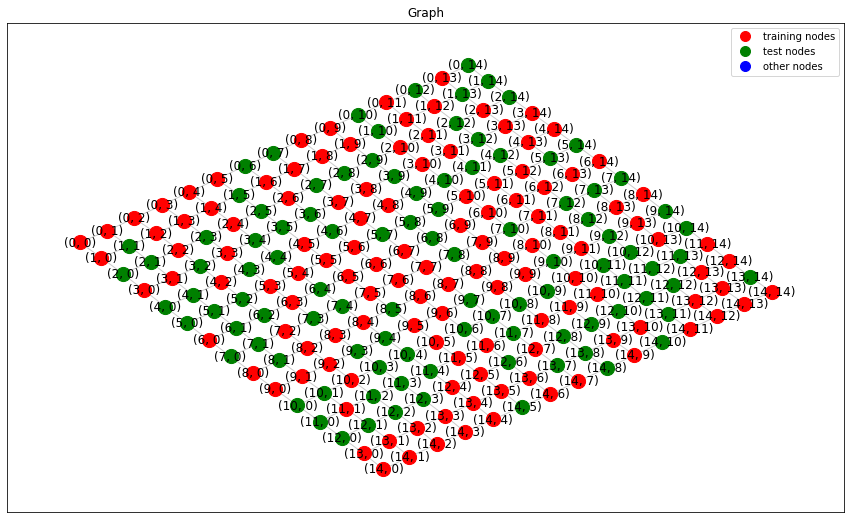

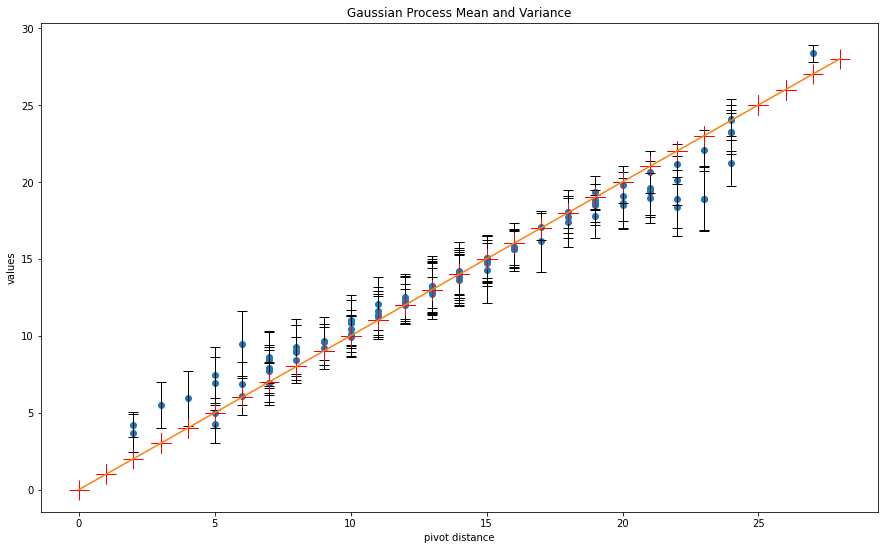

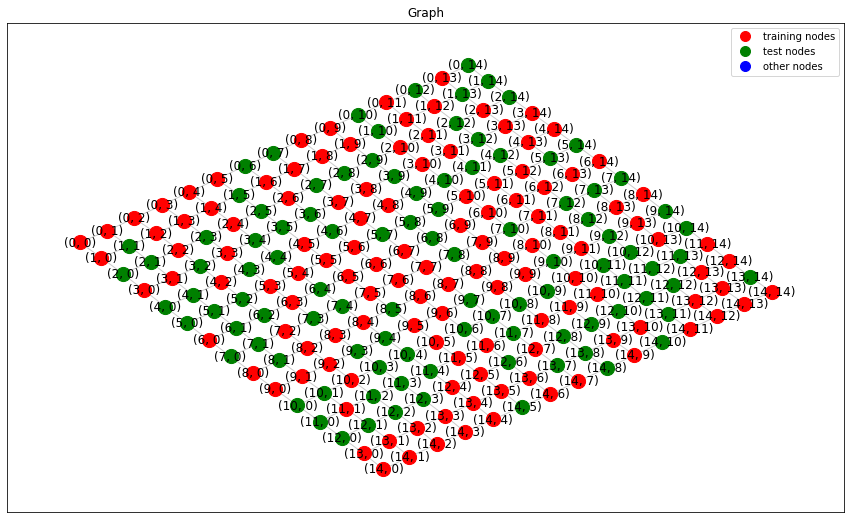

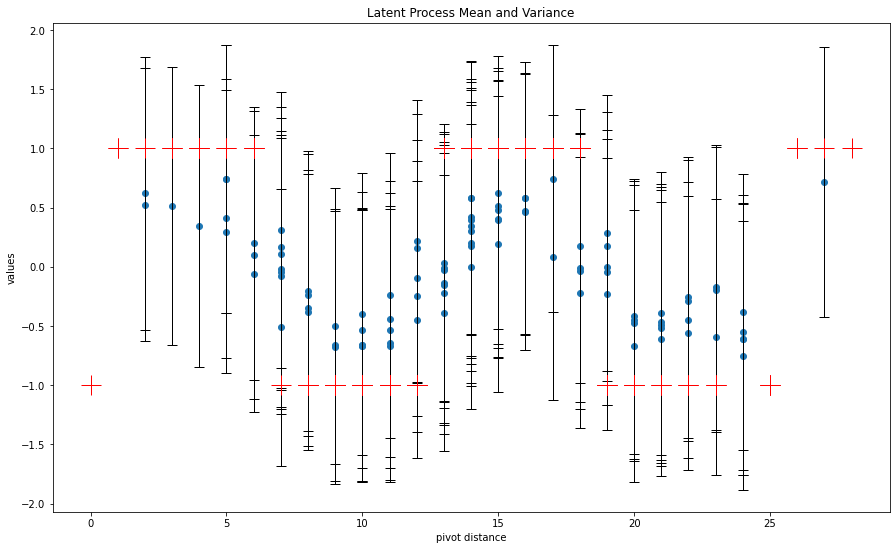

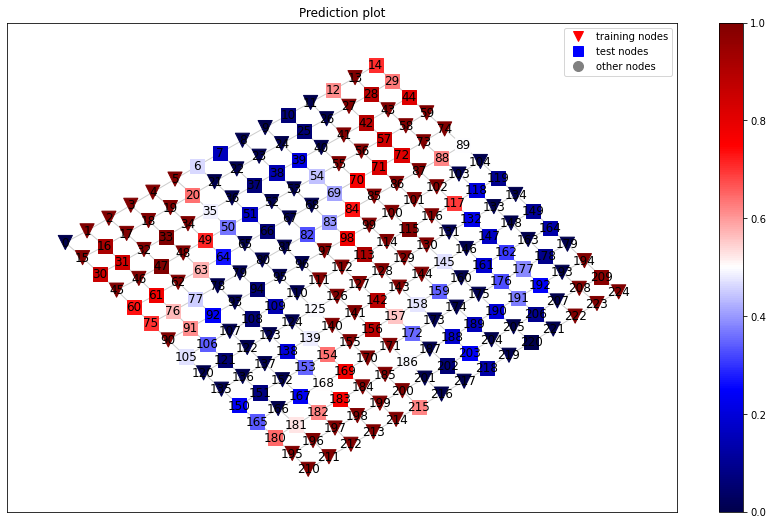

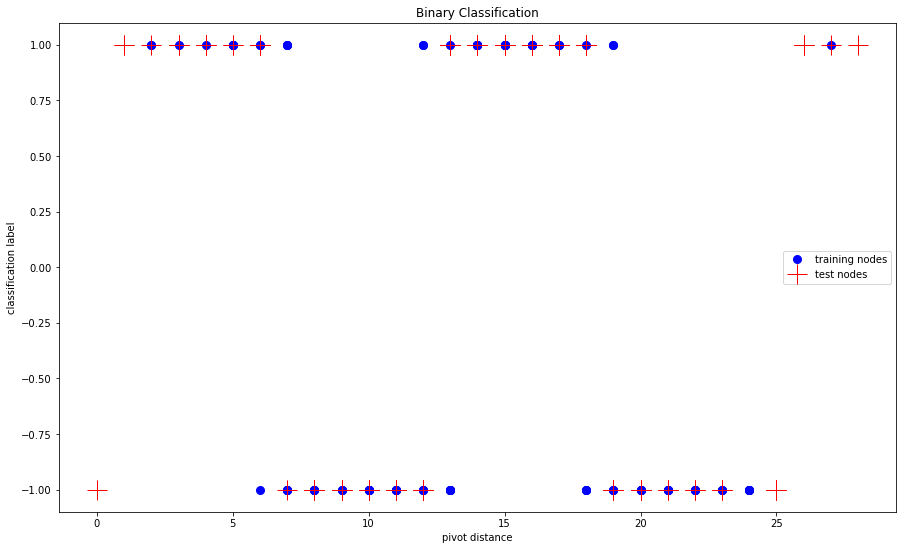

In [12]:
# import sys
# import networkx as nx
# import numpy as np
# sys.path.append('../')

# from GPnetRegressor import GPnetRegressor
# from GPnetClassifier import GPnetClassifier

#%%
lattice_m = 15
lattice_n = 15
G = nx.generators.lattice.grid_graph(dim = [lattice_m,lattice_n],
                                     periodic= False)
#%%

const = np.log(2.3)
const_scale = np.log(2.1)
length_scale= np.log(1.5)
noise = np.log(0.01)


walk_length = np.log(4)

gpr = GPnetRegressor(Graph = G,
                     ntrain = 125,
                     ntest= 100,
                     theta = [const, walk_length, noise],
                     seed = 123,
                     kerneltype = "pstep_walk",
                     relabel_nodes = True)

#%%
gpr.plot_graph()
_ = gpr.predict()
gpr.plot_predict_2d()
#gpr.plot_predict_2d_old()


#%%
labels = (np.sin(0.5*gpr.pivot_distance(0))>0).replace({True: 1, False: -1})
train_nodes = gpr.training_nodes
test_nodes = gpr.test_nodes
train_labels = labels[train_nodes]



#%%
gpc = GPnetClassifier(Graph = G,
                      training_nodes = train_nodes, 
                      test_nodes = test_nodes,
                      training_values = train_labels,
                      theta = [np.log(2.1), np.log(2), np.log(0.1)],
                      seed = 321,
                      kerneltype = 'pstep_walk',
                      relabel_nodes = True)
#%%


#%%
gpc.predict()
gpc.plot_graph()
gpc.plot_latent()
gpc.plot_predict_graph()
gpc.plot_binary_prediction()

In [13]:
G_peak_noibx = nx.read_gml(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\ADS\IBX Project\IBXRidership\Network Processing\base_peak.gml')

In [122]:
G.nodes(data = True)

NodeDataView({(0, 0): {}, (0, 1): {}, (0, 2): {}, (0, 3): {}, (0, 4): {}, (0, 5): {}, (0, 6): {}, (0, 7): {}, (0, 8): {}, (0, 9): {}, (0, 10): {}, (0, 11): {}, (0, 12): {}, (0, 13): {}, (0, 14): {}, (1, 0): {}, (1, 1): {}, (1, 2): {}, (1, 3): {}, (1, 4): {}, (1, 5): {}, (1, 6): {}, (1, 7): {}, (1, 8): {}, (1, 9): {}, (1, 10): {}, (1, 11): {}, (1, 12): {}, (1, 13): {}, (1, 14): {}, (2, 0): {}, (2, 1): {}, (2, 2): {}, (2, 3): {}, (2, 4): {}, (2, 5): {}, (2, 6): {}, (2, 7): {}, (2, 8): {}, (2, 9): {}, (2, 10): {}, (2, 11): {}, (2, 12): {}, (2, 13): {}, (2, 14): {}, (3, 0): {}, (3, 1): {}, (3, 2): {}, (3, 3): {}, (3, 4): {}, (3, 5): {}, (3, 6): {}, (3, 7): {}, (3, 8): {}, (3, 9): {}, (3, 10): {}, (3, 11): {}, (3, 12): {}, (3, 13): {}, (3, 14): {}, (4, 0): {}, (4, 1): {}, (4, 2): {}, (4, 3): {}, (4, 4): {}, (4, 5): {}, (4, 6): {}, (4, 7): {}, (4, 8): {}, (4, 9): {}, (4, 10): {}, (4, 11): {}, (4, 12): {}, (4, 13): {}, (4, 14): {}, (5, 0): {}, (5, 1): {}, (5, 2): {}, (5, 3): {}, (5, 4): {}, (

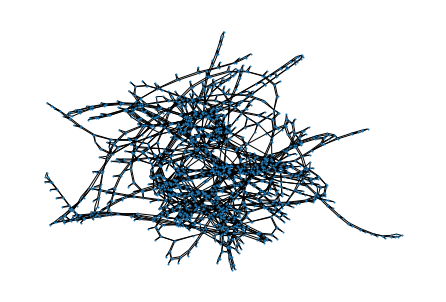

In [15]:
nx.draw(G_peak_noibx,node_size=1)

In [19]:
sw = pd.read_csv(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\ADS\IBX Project\IBXRidership\Network Processing\W_base_peak_tt.csv')
sw.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,414,415,416,417,418,419,420,421,422,423
0,0,0.000000,0.001026,0.002311,0.002277,0.002032,0.002112,0.002836,0.002769,0.002715,...,0.000976,0.002790,0.002811,0.002659,0.002659,0.002563,0.002553,0.002456,0.002419,0.002362
1,1,0.001346,0.000000,0.002141,0.002096,0.001767,0.001873,0.002829,0.002742,0.002671,...,0.000521,0.002762,0.002789,0.002590,0.002590,0.002465,0.002451,0.002323,0.002282,0.002208
2,2,0.002802,0.001978,0.000000,0.000465,0.000797,0.001014,0.001062,0.000981,0.000915,...,0.002030,0.001046,0.000994,0.000874,0.000810,0.000750,0.000681,0.000609,0.000552,0.000486
3,3,0.002807,0.001970,0.000473,0.000000,0.000744,0.000948,0.001121,0.001039,0.000972,...,0.002006,0.001055,0.001050,0.000893,0.000864,0.000776,0.000732,0.000643,0.000602,0.000534
4,4,0.002510,0.001664,0.000812,0.000745,0.000000,0.000638,0.001844,0.001762,0.001695,...,0.001698,0.001370,0.001391,0.001207,0.001204,0.001089,0.001072,0.000956,0.000941,0.000874


In [20]:
sw = sw.iloc[:,1:]

In [21]:
sw.head()

,0,1,2,3,4,5,6,7,8,9,...,414,415,416,417,418,419,420,421,422,423
0,0.000000,0.001026,0.002311,0.002277,0.002032,0.002112,0.002836,0.002769,0.002715,0.002678,...,0.000976,0.002790,0.002811,0.002659,0.002659,0.002563,0.002553,0.002456,0.002419,0.002362
1,0.001346,0.000000,0.002141,0.002096,0.001767,0.001873,0.002829,0.002742,0.002671,0.002622,...,0.000521,0.002762,0.002789,0.002590,0.002590,0.002465,0.002451,0.002323,0.002282,0.002208
2,0.002802,0.001978,0.000000,0.000465,0.000797,0.001014,0.001062,0.000981,0.000915,0.000871,...,0.002030,0.001046,0.000994,0.000874,0.000810,0.000750,0.000681,0.000609,0.000552,0.000486
3,0.002807,0.001970,0.000473,0.000000,0.000744,0.000948,0.001121,0.001039,0.000972,0.000926,...,0.002006,0.001055,0.001050,0.000893,0.000864,0.000776,0.000732,0.000643,0.000602,0.000534
4,0.002510,0.001664,0.000812,0.000745,0.000000,0.000638,0.001844,0.001762,0.001695,0.001649,...,0.001698,0.001370,0.001391,0.001207,0.001204,0.001089,0.001072,0.000956,0.000941,0.000874


In [22]:
cid = pd.read_csv(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\ADS\IBX Project\IBXRidership\Network Processing\station_complex_nodes.csv')
cid.head()

,Unnamed: 0,station_id,station_line,lat,Complex ID,name,lines,boro,long,line_,dir,pf_id,node_id
0,1530,G26,station,40.731352,283,Greenpoint Av,NaN,Bk,-73.954449,G,station,station,G26
1,1531,G24,station,40.744065,282,21 St,NaN,Q,-73.949724,G,station,station,G24
2,1533,G20,station,40.752039,272,36 St,NaN,Q,-73.928781,M R,station,station,G20
3,1534,G21,station,40.748973,273,Queens Plaza,NaN,Q,-73.937243,E M R,station,station,G21
4,1535,G28,station,40.724635,284,Nassau Av,NaN,Bk,-73.951277,G,station,station,G28


In [28]:
cid.shape

(424, 13)

In [27]:
cid = cid[cid['line_'] != 'IBX']

In [29]:
cid.sort_values(by=['Complex ID'],ignore_index=True,inplace=True)
cid.head()

,Unnamed: 0,station_id,station_line,lat,Complex ID,name,lines,boro,long,line_,dir,pf_id,node_id
0,1782,R01,station,40.775036,1,Astoria - Ditmars Blvd,NaN,Q,-73.912034,N W,station,station,R01
1,1918,R15,station,40.759901,10,49 St,NaN,M,-73.984139,N R W,station,station,R15
2,1745,M14,station,40.706870,100,Hewes St,NaN,Bk,-73.953431,J M,station,station,M14
3,1747,M16,station,40.708359,101,Marcy Av,NaN,Bk,-73.957757,J M Z,station,station,M16
4,1748,M19,station,40.720280,103,Bowery,NaN,M,-73.993915,J Z,station,station,M19


In [36]:
sw.set_index(cid['Complex ID'],inplace=True)
sw.columns = 'd' + cid['Complex ID']
sw.head()

Complex ID,d1,d10,d100,d101,d103,d107,d108,d109,d110,d111,...,d9,d90,d91,d93,d94,d95,d96,d97,d98,d99
Complex ID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.001026,0.002311,0.002277,0.002032,0.002112,0.002836,0.002769,0.002715,0.002678,...,0.000976,0.002790,0.002811,0.002659,0.002659,0.002563,0.002553,0.002456,0.002419,0.002362
10,0.001346,0.000000,0.002141,0.002096,0.001767,0.001873,0.002829,0.002742,0.002671,0.002622,...,0.000521,0.002762,0.002789,0.002590,0.002590,0.002465,0.002451,0.002323,0.002282,0.002208
100,0.002802,0.001978,0.000000,0.000465,0.000797,0.001014,0.001062,0.000981,0.000915,0.000871,...,0.002030,0.001046,0.000994,0.000874,0.000810,0.000750,0.000681,0.000609,0.000552,0.000486
101,0.002807,0.001970,0.000473,0.000000,0.000744,0.000948,0.001121,0.001039,0.000972,0.000926,...,0.002006,0.001055,0.001050,0.000893,0.000864,0.000776,0.000732,0.000643,0.000602,0.000534
103,0.002510,0.001664,0.000812,0.000745,0.000000,0.000638,0.001844,0.001762,0.001695,0.001649,...,0.001698,0.001370,0.001391,0.001207,0.001204,0.001089,0.001072,0.000956,0.000941,0.000874


Complex ID,Complex ID,d1,d10,d100,d101,d103,d107,d108,d109,d110,...,d9,d90,d91,d93,d94,d95,d96,d97,d98,d99
0,1,0.000000,0.001026,0.002311,0.002277,0.002032,0.002112,0.002836,0.002769,0.002715,...,0.000976,0.002790,0.002811,0.002659,0.002659,0.002563,0.002553,0.002456,0.002419,0.002362
1,10,0.001346,0.000000,0.002141,0.002096,0.001767,0.001873,0.002829,0.002742,0.002671,...,0.000521,0.002762,0.002789,0.002590,0.002590,0.002465,0.002451,0.002323,0.002282,0.002208
2,100,0.002802,0.001978,0.000000,0.000465,0.000797,0.001014,0.001062,0.000981,0.000915,...,0.002030,0.001046,0.000994,0.000874,0.000810,0.000750,0.000681,0.000609,0.000552,0.000486
3,101,0.002807,0.001970,0.000473,0.000000,0.000744,0.000948,0.001121,0.001039,0.000972,...,0.002006,0.001055,0.001050,0.000893,0.000864,0.000776,0.000732,0.000643,0.000602,0.000534
4,103,0.002510,0.001664,0.000812,0.000745,0.000000,0.000638,0.001844,0.001762,0.001695,...,0.001698,0.001370,0.001391,0.001207,0.001204,0.001089,0.001072,0.000956,0.000941,0.000874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,95,0.002778,0.002036,0.000670,0.000682,0.000956,0.001135,0.001276,0.001203,0.001145,...,0.002065,0.000625,0.000598,0.000483,0.000433,0.000000,0.000441,0.000497,0.000557,0.000616
420,96,0.002753,0.002015,0.000606,0.000641,0.000936,0.001129,0.001217,0.001145,0.001087,...,0.002044,0.000703,0.000656,0.000550,0.000493,0.000439,0.000000,0.000442,0.000493,0.000552
421,97,0.002876,0.002074,0.000588,0.000611,0.000907,0.001101,0.000842,0.000764,0.000701,...,0.002106,0.000802,0.000782,0.000648,0.000604,0.000537,0.000480,0.000000,0.000466,0.000530
422,98,0.002847,0.002048,0.000536,0.000575,0.000897,0.001108,0.000904,0.000825,0.000761,...,0.002098,0.000892,0.000841,0.000725,0.000663,0.000604,0.000538,0.000468,0.000000,0.000477


In [98]:
e_list = pd.wide_to_long(sw.reset_index(),stubnames='d',i='Complex ID',j='dest')
e_list

,,d
Complex ID,dest,
1,1,0.000000
10,1,0.001346
100,1,0.002802
101,1,0.002807
103,1,0.002510
...,...,...
95,99,0.000616
96,99,0.000552
97,99,0.000530


In [99]:
e_list = e_list.reset_index()
e_list.columns = ['o','d','w']
e_list.d = e_list.d.astype(str)
e_list

,o,d,w
0,1,1,0.000000
1,10,1,0.001346
2,100,1,0.002802
3,101,1,0.002807
4,103,1,0.002510
...,...,...,...
179771,95,99,0.000616
179772,96,99,0.000552
179773,97,99,0.000530
179774,98,99,0.000477


In [100]:
e_list = e_list[e_list.w != 0]
e_list.shape


(179352, 3)

In [101]:
e_list['od'] = np.where(e_list['o'] < e_list['d'],e_list['o'] + '_' + e_list['d'],e_list['d'] + '_' + e_list['o'])
e_list

C:\Users\Gabriel\AppData\Local\Temp/ipykernel_33964/4095147188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_list['od'] = np.where(e_list['o'] < e_list['d'],e_list['o'] + '_' + e_list['d'],e_list['d'] + '_' + e_list['o'])


,o,d,w,od
1,10,1,0.001346,1_10
2,100,1,0.002802,1_100
3,101,1,0.002807,1_101
4,103,1,0.002510,1_103
5,107,1,0.002523,1_107
...,...,...,...,...
179770,94,99,0.000652,94_99
179771,95,99,0.000616,95_99
179772,96,99,0.000552,96_99
179773,97,99,0.000530,97_99


In [102]:
e_list = e_list.drop_duplicates(subset='od')
e_list.shape

(89676, 4)

In [105]:
e_list.drop('od',axis=1,inplace=True)
e_list

C:\Users\Gabriel\anaconda3\envs\ADS2\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,o,d,w
1,10,1,0.001346
2,100,1,0.002802
3,101,1,0.002807
4,103,1,0.002510
5,107,1,0.002523
...,...,...,...
178502,98,96,0.000538
178503,99,96,0.000611
178926,98,97,0.000468
178927,99,97,0.000541


In [110]:
G_peak_noibx = nx.from_pandas_dataframe(e_list, 'o', 'd', edge_attr=['w'])
G_peak_noibx.nodes

AttributeError: module networkx has no attribute from_pandas_dataframe

In [111]:
G_peak_noibx=nx.Graph()
for i in e_list.index:
   G_peak_noibx.add_edge(e_list.o[i],e_list.d[i], weight=e_list.w[i])

In [152]:
node_att = pd.read_csv(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\ADS\IBX Project\IBXRidership\mg_noIBX_log.csv')
node_att.head()

,Unnamed: 0,complex_id,Stop Name,Complex_id,exits_weekday_evening,entries_weekday_evening,exits_weekday_morning,entries_weekday_morning,exits_weekday_overnight,entries_weekday_overnight,...,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops,geometry,Complex ID,boro,lat,long
0,0,614,59 ST-COLUMBUS CIRCLE,614c,9.298917,9.651250,10.135658,9.403225,6.793914,6.521357,...,6.307799,9.124523,8.935287,7.366636,3.367296,POLYGON ((990236.0543776825 218861.07537803546...,614,M,40.768271,-73.981832
1,1,611,42 ST-PORT AUTHORITY BUS TERMINAL,611c,10.769301,10.378974,10.854118,10.483263,8.248025,8.394240,...,5.465907,8.447817,8.309334,6.402368,3.091042,POLYGON ((986940.1379654831 213865.68954273767...,611,M,40.755746,-73.987581
2,2,601,14 ST,601c,8.989270,9.062817,9.509187,8.865527,6.546893,6.129105,...,6.175631,8.908649,8.777927,6.809322,2.397895,"POLYGON ((984311.361812786 208635.71960600044,...",601,M,40.737796,-73.997732
3,3,635,SOUTH FERRY,635c,8.796464,8.775997,9.015067,8.601594,6.962243,6.234166,...,3.869901,6.232502,6.013846,4.604913,2.564949,POLYGON ((980986.4055763358 195840.87311689934...,635,M,40.702249,-74.013100
4,4,620,BOROUGH HALL,620c,8.425664,8.806297,9.177489,8.869838,5.891161,5.330543,...,6.420271,8.592603,8.509023,6.069158,3.218876,"POLYGON ((983946.3076435457 190667.0264045154,...",620,Bk,40.693241,-73.990642


In [153]:
node_att.complex_id = node_att.complex_id.astype(str)

In [137]:
node_att_dic = node_att[['complex_id','exits_weekday_evening']].set_index('complex_id').to_dict('index')
nx.set_node_attributes(G_peak_noibx, node_att_dic)


In [138]:
G_peak_noibx.nodes(data=True)

NodeDataView({'10': {'exits_weekday_evening': 4729.8}, '1': {'exits_weekday_evening': 5725.625}, '100': {'exits_weekday_evening': 936.975}, '101': {'exits_weekday_evening': 3902.65}, '103': {'exits_weekday_evening': 936.15}, '107': {'exits_weekday_evening': 436.55}, '108': {'exits_weekday_evening': 1344.65}, '109': {'exits_weekday_evening': 3254.175}, '110': {'exits_weekday_evening': 1621.55}, '111': {'exits_weekday_evening': 1471.4}, '113': {'exits_weekday_evening': 1916.4}, '114': {'exits_weekday_evening': 1769.05}, '118': {'exits_weekday_evening': 1758.85}, '119': {'exits_weekday_evening': 7446.55}, '120': {'exits_weekday_evening': 11705.076923076924}, '122': {'exits_weekday_evening': 2526.15}, '123': {'exits_weekday_evening': 2031.975}, '124': {'exits_weekday_evening': 1598.65}, '125': {'exits_weekday_evening': 1379.6}, '126': {'exits_weekday_evening': 759.675}, '127': {'exits_weekday_evening': 1237.025}, '129': {'exits_weekday_evening': 2281.35}, '13': {'exits_weekday_evening': 25

In [ ]:
GPnetRegressor()

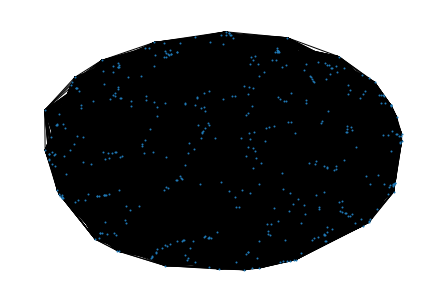

In [108]:
nx.draw(G_peak_noibx,node_size=1)

> Relabeling nodes, orig. names stored in self.orig_labels_dict
> Assigning Nodes Randomly ( seed = 123 )
400  training nodes
24  test nodes
0  idle nodes
succesfully trained model
> Relabeling nodes, orig. names stored in self.orig_labels_dict


C:\Users\Gabriel\AppData\Local\Temp/ipykernel_33964/635772962.py:583: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probs_series0 = pd.Series(index = self.test_nodes)
C:\Users\Gabriel\AppData\Local\Temp/ipykernel_33964/635772962.py:584: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probs_series1 = pd.Series(index = self.test_nodes)
C:\Users\Gabriel\AppData\Local\Temp/ipykernel_33964/635772962.py:585: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicted_class_series = pd.Series(index = self.test_nodes)


succesfully trained model


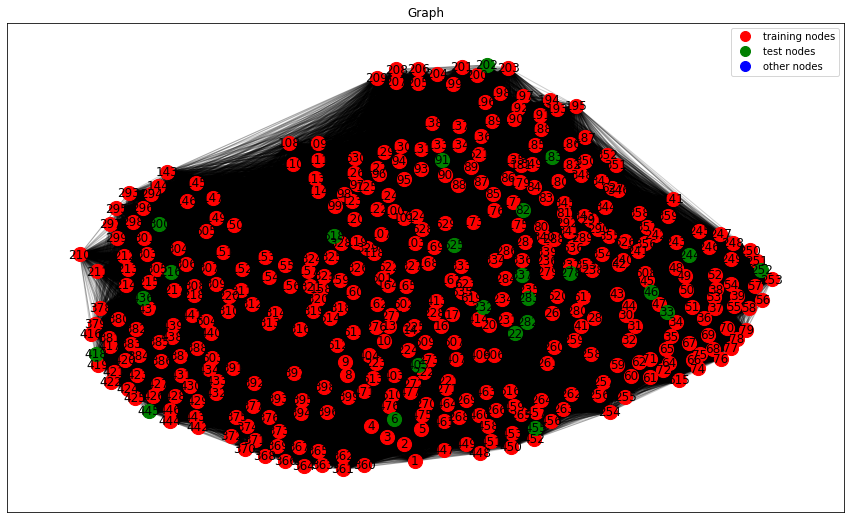

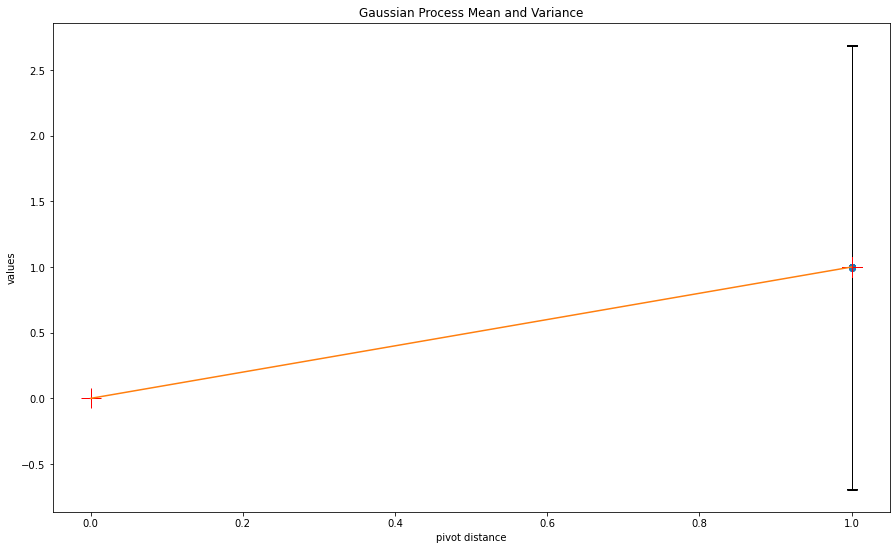

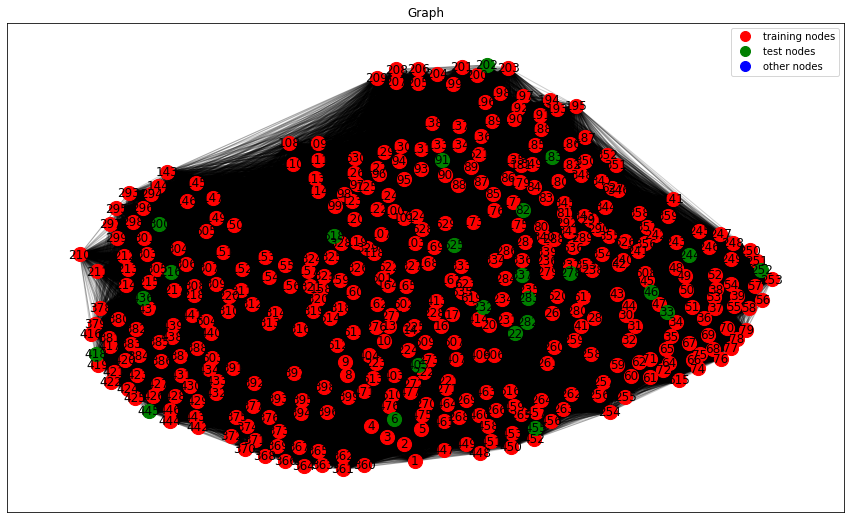

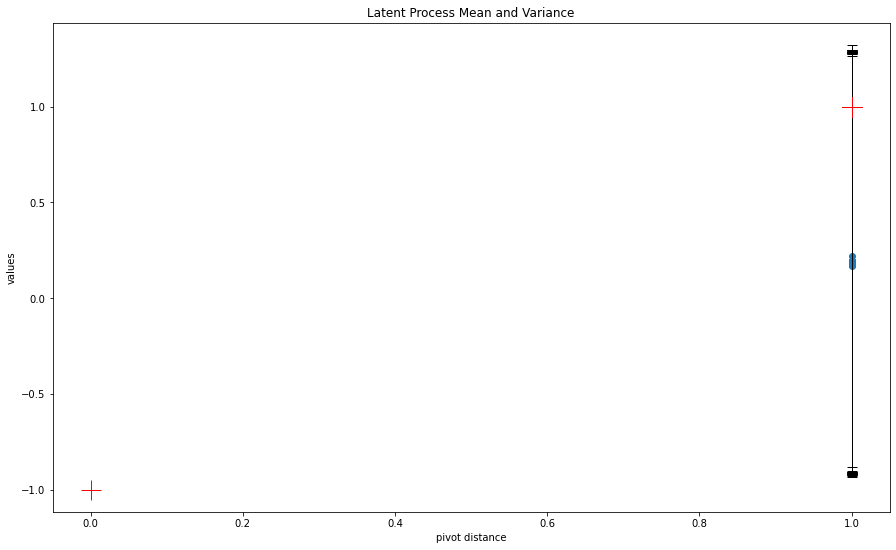

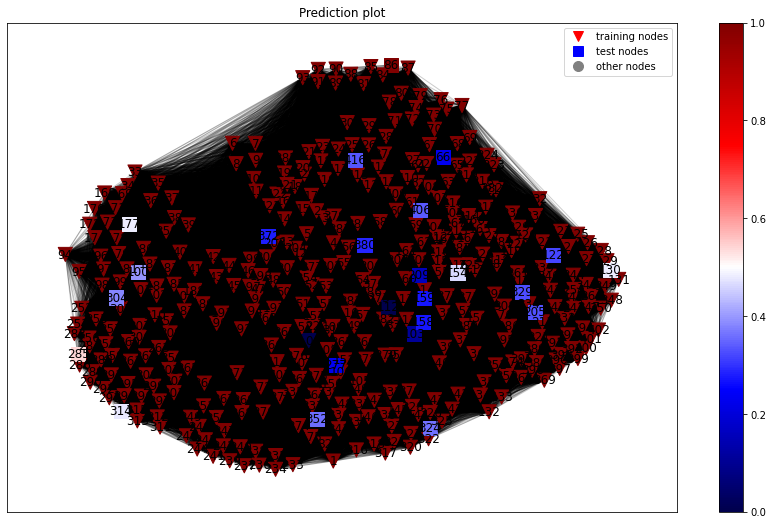

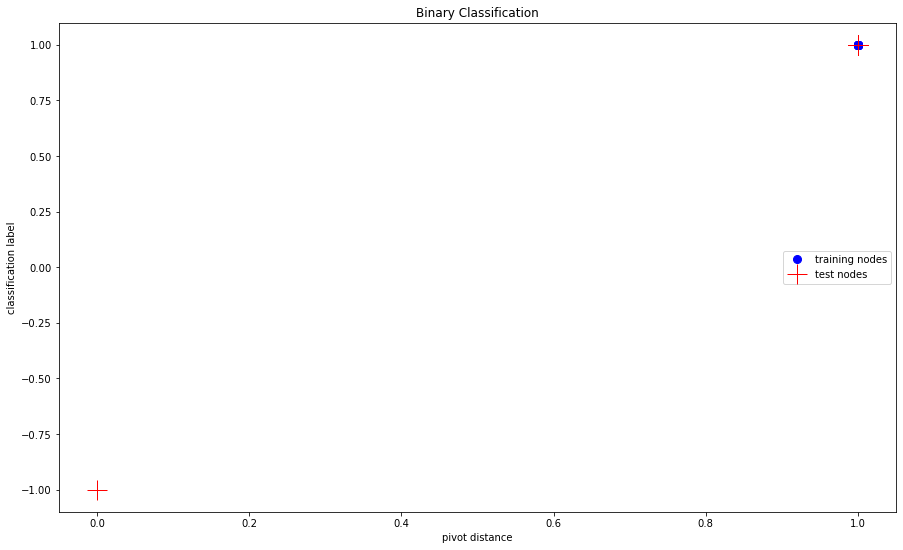

In [139]:
#%%

const = np.log(2.3)
const_scale = np.log(2.1)
length_scale= np.log(1.5)
noise = np.log(0.01)


walk_length = np.log(4)

gpr = GPnetRegressor(Graph = G_peak_noibx,
                     ntrain = 400,
                     ntest= 24,
                     theta = [const, walk_length, noise],
                     seed = 123,
                     kerneltype = "pstep_walk",
                     relabel_nodes = True)

#%%
gpr.plot_graph()
_ = gpr.predict()
gpr.plot_predict_2d()
#gpr.plot_predict_2d_old()


#%%
labels = (np.sin(0.5*gpr.pivot_distance(0))>0).replace({True: 1, False: -1})
train_nodes = gpr.training_nodes
test_nodes = gpr.test_nodes
train_labels = labels[train_nodes]



#%%
gpc = GPnetClassifier(Graph = G_peak_noibx,
                      training_nodes = train_nodes, 
                      test_nodes = test_nodes,
                      training_values = train_labels,
                      theta = [np.log(2.1), np.log(2), np.log(0.1)],
                      seed = 321,
                      kerneltype = 'pstep_walk',
                      relabel_nodes = True)
#%%


#%%
gpc.predict()
gpc.plot_graph()
gpc.plot_latent()
gpc.plot_predict_graph()
gpc.plot_binary_prediction()

In [149]:
e_list

,o,d,w
1,10,1,0.001346
2,100,1,0.002802
3,101,1,0.002807
4,103,1,0.002510
5,107,1,0.002523
...,...,...,...
178502,98,96,0.000538
178503,99,96,0.000611
178926,98,97,0.000468
178927,99,97,0.000541


In [150]:
node_att.head()

,Unnamed: 0,complex_id,Stop Name,Complex_id,exits_weekday_evening,entries_weekday_evening,exits_weekday_morning,entries_weekday_morning,exits_weekday_overnight,entries_weekday_overnight,...,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops,geometry,Complex ID,boro,lat,long
0,0,614,59 ST-COLUMBUS CIRCLE,614c,10926.175,15541.200,25226.700,12127.425,892.400,679.500,...,0.000116,0.001933,0.001600,0.000333,29.0,POLYGON ((990236.0543776825 218861.07537803546...,614,M,40.768271,-73.981832
1,1,611,42 ST-PORT AUTHORITY BUS TERMINAL,611c,47538.800,32175.925,51746.825,35712.750,3820.075,4421.525,...,0.000053,0.001055,0.000919,0.000136,22.0,POLYGON ((986940.1379654831 213865.68954273767...,611,M,40.755746,-73.987581
2,2,601,14 ST,601c,8016.600,8628.425,13483.025,7083.525,697.075,459.025,...,0.000146,0.002251,0.001975,0.000276,11.0,"POLYGON ((984311.361812786 208635.71960600044,...",601,M,40.737796,-73.997732
3,3,635,SOUTH FERRY,635c,6610.825,6476.900,8226.100,5440.325,1056.000,509.875,...,0.000026,0.000271,0.000218,0.000053,13.0,POLYGON ((980986.4055763358 195840.87311689934...,635,M,40.702249,-74.013100
4,4,620,BOROUGH HALL,620c,4562.675,6676.150,9676.825,7114.125,361.825,206.550,...,0.000130,0.001140,0.001049,0.000091,25.0,"POLYGON ((983946.3076435457 190667.0264045154,...",620,Bk,40.693241,-73.990642


In [154]:
noat = node_att[['complex_id','exits_weekday_evening','cs_noibx_peak','lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs',
       'numfloors', 'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops']]

In [158]:
mg = pd.merge(e_list,noat,left_on='o',right_on='complex_id',how='left').fillna(0)

In [164]:
data = mg
init_feat1 = np.array(data.groupby('o')['cs_noibx_peak'].agg(['unique']))
init_feat1 = np.array(list(map(lambda x: x[0][0], init_feat1))).reshape(-1, 1)
init_feat2 = np.array(data.groupby('o')['lotarea'].agg(['unique']))
init_feat2 = np.array(list(map(lambda x: x[0][0], init_feat2))).reshape(-1, 1)
# init_feat3 = np.array(data.groupby('origin')['area'].agg(['unique']))
# init_feat3 = np.array(list(map(lambda x: x[0][0], init_feat3))).reshape(-1, 1)
# init_feat4 = np.array(data.groupby('origin')['income'].agg(['unique']))
# init_feat4 = np.array(list(map(lambda x: x[0][0], init_feat4))).reshape(-1, 1)
# init_feat5 = np.array(data.groupby('origin')['jobs'].agg(['unique']))
# init_feat5 = np.array(list(map(lambda x: x[0][0], init_feat5))).reshape(-1, 1)

init_feat = np.concatenate([init_feat1,init_feat2],axis=1)

In [167]:
init_feat.shape

(423, 2)

In [170]:
np.array(noat).shape

(424, 33)

In [174]:
# function for loading data, returns adjacency matrix, initial feature assignments and true labels

def load_data(edge_list_df, node_attributes_df):

    G = nx.from_pandas_edgelist(data, 'o', 'd', 'w')
    adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
    
    init_feat = np.array(node_attributes_df.loc[:,'cs_noibx_peak':])
    
    true_label = np.array(node_attributes_df.loc[:,'exits_weekday_evening'])
    
    #true_label = np.array(list(map(lambda x: x[0][0], true_label))).reshape(-1, 1)
    return adj_list,init_feat, true_label

adj,feature,labels = load_data(mg, noat)

features = np.expand_dims(feature, axis=0)

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
torch.set_printoptions(sci_mode=False)
import time

In [141]:
cuda = torch.cuda.is_available()
weight_decay = 1e-8
epochs = 10000
seed = 635
hidden = 16
lr = 0.0001

In [142]:
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [144]:
def normalize(adj):

    adj = torch.FloatTensor(adj)
    adj_id = torch.FloatTensor(torch.eye(adj.shape[1]))
    adj_id = adj_id.reshape((1, adj.shape[1], adj.shape[1]))
    adj_id = adj_id.repeat(adj.shape[0], 1, 1)
    adj = adj + adj_id
    rowsum = torch.FloatTensor(adj.sum(2))
    degree_mat_inv_sqrt = torch.diag_embed(torch.float_power(rowsum,-0.5), dim1=-2, dim2=-1).float()
    adj_norm = torch.bmm(torch.transpose(torch.bmm(adj,degree_mat_inv_sqrt),1,2),degree_mat_inv_sqrt)

    return adj_norm

In [143]:
def doublerelu(x):
    return torch.clamp(x, 0, 1)

In [145]:
class GNN1Layer(Module):

    def __init__(self, batch_size, in_features, out_features, first):
        super(GNN1Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        
        # Initialse W1 = 1, W2 = 0 as pytorch learnable weights (parameters) that have require_grad = True which is
        # required for calculating gradients while backpropogating using gradient descent
        weight1_eye = torch.FloatTensor(torch.eye(in_features, out_features))
        weight1_eye = weight1_eye.reshape((1, in_features, out_features))
        weight1_eye = weight1_eye.repeat(batch_size, 1, 1)
        self.weight1 = Parameter(weight1_eye)
        if not first:
            self.weight2 = Parameter(torch.zeros(batch_size, in_features, out_features))
        else:
            self.weight2 = Parameter(torch.empty(batch_size, in_features, out_features))
            nn.init.kaiming_normal_(self.weight2, mode='fan_out')

    def forward(self, input, adj):
        # first term H*W1
        v1 = torch.bmm(input, self.weight1)
        # second term adj_norm*H*W2
        v2 = torch.bmm(torch.bmm(adj, input), self.weight2)
        # adding the two terms
        output = v1 + v2

        return output

In [146]:
class GNN1(nn.Module):

    def __init__(self, batch_size, nfeat, ndim, hidden, first):
        super(GNN1, self).__init__()

        self.gc1 = GNN1Layer(batch_size, nfeat, hidden, first)
        self.gc2 = GNN1Layer(batch_size, hidden, ndim, first)

    def forward(self, x, adj):

        # Applying activation function sigma (doublerelu) on the layer propogation
        x = doublerelu(self.gc1(x, adj))
        x = doublerelu(self.gc2(x, adj))
        x = x/x.sum(axis=2).unsqueeze(2) #normalize st sum = 1
        
        return x

tensor([[[0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         ...,
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024],
         [0.0024, 0.0024, 0.0024,  ..., 0.0024, 0.0024, 0.0024]]])

In [147]:
def train(adj,features,labels,train_indices,val_indices,first=False):
    
    # calculate symmetric normalisation for layer propogation
    adj_norm = normalize(adj)
    
    # labels = labels - 1
    
    # Convert from numpy to torch tensors
    adj = torch.FloatTensor(adj)
    adj_norm = torch.FloatTensor(adj_norm)
    features = torch.FloatTensor(features)
    labels = torch.FloatTensor(labels)
    
    # initialise the model
    model = GNN1(batch_size=adj.shape[0],
                nfeat=features.shape[-1],
                ndim=5,
                hidden=hidden,
                first=first)
    
    # Transfer the weights to GPU for training
    if cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()
        labels = labels.cuda()
    
    # Train model
    t_total = time.time()

    # Using adam optimizers for backpropogation
    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)
    
    # loss function criteria is cross entropy loss
    criterion = nn.CrossEntropyLoss()
    
    # Train for the no of epochs
    for epoch in range(epochs):

        t = time.time()
        
        model.train()
        
        # Pytorch accumulates gradient after every operation on tensors (defined by the model architecture)
        # with require_grad = True. With each new epoch, we need to reset this gradient to 0 to calculate gradient
        # for this epoch.
        optimizer.zero_grad()

        # get the output from forward propogation of our model
        output = model(features, adj_norm)
        
        # Calculate Train accuracy
        train_output = output[:,train_indices,:]
        train_labels = labels[train_indices,:]
        train_accuracy = torch.sum(torch.argmax(train_output,axis=2)==train_labels.reshape(1,-1))/train_labels.shape[0]
        
        # Calculate the loss between our models training output and true label
        loss = criterion(output[0],labels.reshape(-1).long())
        
        # Calculate the gradients 
        loss.backward(retain_graph=True)

        # Update the weights
        optimizer.step()
        
        model.eval()
        
        # Calculate Validation accuracy
        with torch.no_grad():
            val_output = output[:,val_indices,:]
            val_labels = labels[val_indices,:]
            val_accuracy = torch.sum(torch.argmax(val_output,axis=2)==val_labels.reshape(1,-1))/val_labels.shape[0]

        # Print summary of training 
        if epoch == 0:
            best_loss = loss
            best_output = output
            best_acc = train_accuracy
            best_val_acc = val_accuracy
            best_val_output = val_output
        else:
            if loss < best_loss:
                best_loss = loss
                best_output = output
                best_acc = train_accuracy
                best_val_acc = val_accuracy
                best_val_output = val_output

        if epoch == 0 or (epoch+1) % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'Train Accuracy: {:.4f}'.format(best_acc.item()),
                  'Validation Accuracy: {:.4f}'.format(best_val_acc.item()),
                  'Loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return best_loss,best_output#,best_val_output

In [175]:
# set Train %

train_percentage = .8
    
# Train set
number_of_rows = features[0].shape[0]
train_indices = np.random.choice(number_of_rows, size=int(train_percentage*number_of_rows), replace=False)
val_indices = np.setdiff1d(np.arange(adj.shape[1]),train_indices)

# Start Train
prev_loss, op = train(adj,features,labels,train_indices,val_indices,True)

# Keep training recurrently until the loss stops decreasing
loss, op = train(adj,op.cpu().detach().numpy(),labels,train_indices,val_indices)
while loss < prev_loss :
    prev_loss = loss
    loss, op = train(adj,op.cpu().detach().numpy(),labels,train_indices,val_indices)

IndexError: too many indices for tensor of dimension 1